In [79]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
from pydub import AudioSegment
from glob import glob
import sox
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import IPython.display as ipd

In [80]:
os.listdir('data')

['.DS_Store',
 'train_10sec_sample',
 'test.csv',
 'train_10sec_16khz',
 'train_10sec_sample_features',
 'example_test_audio',
 'train_split.csv',
 'example_test_audio_metadata.csv',
 'train_audio',
 'mel_spec_16khz',
 'audio_10sec_augmented',
 'example_test_audio_summary.csv',
 'test_split.csv',
 'train.csv',
 'audio_split',
 'audio_10sec',
 'audio_10sec_features',
 'birdsong-recognition.zip',
 'sample_submission.csv']

# Look at provided DataFrame

In [81]:
df = pd.read_csv('data/train.csv')
df.head()

rating playback_used ebird_code    channels        date          pitch  \
0     3.5            no     aldfly    1 (mono)  2013-05-25  Not specified   
1     4.0            no     aldfly  2 (stereo)  2013-05-27           both   
2     4.0            no     aldfly  2 (stereo)  2013-05-27           both   
3     3.5            no     aldfly  2 (stereo)  2013-05-27           both   
4     4.0            no     aldfly  2 (stereo)  2013-05-27           both   

   duration      filename          speed           species  ...   xc_id  \
0        25  XC134874.mp3  Not specified  Alder Flycatcher  ...  134874   
1        36  XC135454.mp3           both  Alder Flycatcher  ...  135454   
2        39  XC135455.mp3           both  Alder Flycatcher  ...  135455   
3        33  XC135456.mp3           both  Alder Flycatcher  ...  135456   
4        36  XC135457.mp3          level  Alder Flycatcher  ...  135457   

                                 url        country            author  \
0  https://www.xeno-canto.org/134874  United States  Jonathon Jongsma   
1  https://www.xeno-canto.org/135454  United States       Mike Nelson   
2  https://www.xeno-canto.org/135455  United States       Mike Nelson   
3  https://www.xeno-canto.org/135456  United States       Mike Nelson   
4  https://www.xeno-canto.org/135457  United States       Mike Nelson   

                        primary_label longitude         length   time  \
0  Empidonax alnorum_Alder Flycatcher   -92.962  Not specified   8:00   
1  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   
2  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   
3  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   
4  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   

          recordist                                            license  
0  Jonathon Jongsma        Creative Commons Attribution-ShareAlike 3.0  
1       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
2       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
3       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
4       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  

[5 rows x 35 columns]

In [82]:
df.columns

Index(['rating', 'playback_used', 'ebird_code', 'channels', 'date', 'pitch',
       'duration', 'filename', 'speed', 'species', 'number_of_notes', 'title',
       'secondary_labels', 'bird_seen', 'sci_name', 'location', 'latitude',
       'sampling_rate', 'type', 'elevation', 'description', 'bitrate_of_mp3',
       'file_type', 'volume', 'background', 'xc_id', 'url', 'country',
       'author', 'primary_label', 'longitude', 'length', 'time', 'recordist',
       'license'],
      dtype='object')

**Knows column values**

`rating` - Rate the quality of this recording 0 - 5 (0 is worst) originally (A is best, E worst)

`playback_used` - was playback used to lure the bird? (yes/no)

`ebird_code`: a code for the bird species. You can review detailed information about the bird codes by appending the code to https://ebird.org/species/, such as https://ebird.org/species/amecro for the American Crow

`channels` - mono or stereo recording

`date` - the date that the recording was 

`pitch` - Describes the pitch shape of the observed sound

`recodist`: the user who provided the recording.

`location`: where the recording was taken. Some bird species may have local call 'dialects', so you may want to seek geographic diversity in your training data.

`date`: while some bird calls can be made year round, such as an alarm call, some are restricted to a specific season. You may want to seek temporal diversity in your training data.

`filename`: the name of the associated audio file.

**API values**
    
    id: the catalogue number of the recording on xeno-canto
    gen: the generic name of the species
    sp: the specific name (epithet) of the species
    ssp: the subspecies name (subspecific epithet)
    en: the English name of the species
    rec: the name of the recordist
    cnt: the country where the recording was made
    loc: the name of the locality
    lat: the latitude of the recording in decimal coordinates
    lng: the longitude of the recording in decimal coordinates
    type: the sound type of the recording (e.g. 'call', 'song', etc). This is generally a comma-separated list of sound types.
    url: the URL specifying the details of this recording
    file: the URL to the audio file
    file-name: the original file name of the audio file
    sono: an object with the urls to the four versions of sonograms
    lic: the URL describing the license of this recording
    q: the current quality rating for the recording
    length: the length of the recording in minutes
    time: the time of day that the recording was made
    date: the date that the recording was made
    uploaded: the date that the recording was uploaded to xeno-canto
    also: an array with the identified background species in the recording
    rmk: additional remarks by the recordist
    bird-seen: was the recorded bird visually identified? (yes/no)
    playback-used: was playback used to lure the bird? (yes/no)


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21375 entries, 0 to 21374
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            21375 non-null  float64
 1   playback_used     19575 non-null  object 
 2   ebird_code        21375 non-null  object 
 3   channels          21375 non-null  object 
 4   date              21375 non-null  object 
 5   pitch             21375 non-null  object 
 6   duration          21375 non-null  int64  
 7   filename          21375 non-null  object 
 8   speed             21375 non-null  object 
 9   species           21375 non-null  object 
 10  number_of_notes   21375 non-null  object 
 11  title             21375 non-null  object 
 12  secondary_labels  21375 non-null  object 
 13  bird_seen         19575 non-null  object 
 14  sci_name          21375 non-null  object 
 15  location          21375 non-null  object 
 16  latitude          21375 non-null  object

All of the columns are object except xc_id, duration, and rating.  This probably means that many of the columns have missing values.  I won't tackle them unless necessary.

In [84]:
df.describe()

rating      duration          xc_id
count  21375.000000  21375.000000   21375.000000
mean       4.068047     55.806784  285004.752140
std        0.988122     76.385696  125160.991016
min        0.000000      0.000000    1634.000000
25%        3.500000     15.000000  174094.500000
50%        4.000000     33.000000  293438.000000
75%        5.000000     68.000000  386885.500000
max        5.000000   2283.000000  505611.000000

Hmm, what does duration 0 mean??

In [85]:
df[['duration', 'length']]

duration         length
0            25  Not specified
1            36         0-3(s)
2            39         0-3(s)
3            33         0-3(s)
4            36         0-3(s)
...         ...            ...
21370        28         0-3(s)
21371        52  Not specified
21372        96  Not specified
21373        35         >10(s)
21374       103         >10(s)

[21375 rows x 2 columns]

In [86]:
df['length'].unique()

array(['Not specified', '0-3(s)', '6-10(s)', '>10(s)', '3-6(s)'],
      dtype=object)

That is interesting, but not insightful.  `duration` is not related to the length of the file.

In [87]:
# how much of this data is more than 10 seconds long?
len(df[df['length'] == '>10(s)'])/len(df)

0.025497076023391813

In [88]:
df.playback_used.unique()

array(['no', nan, 'yes'], dtype=object)

In [89]:
len(df['ebird_code'].unique())

264

In [90]:
df['ebird_code'].unique()


array(['aldfly', 'ameavo', 'amebit', 'amecro', 'amegfi', 'amekes',
       'amepip', 'amered', 'amerob', 'amewig', 'amewoo', 'amtspa',
       'annhum', 'astfly', 'baisan', 'baleag', 'balori', 'banswa',
       'barswa', 'bawwar', 'belkin1', 'belspa2', 'bewwre', 'bkbcuc',
       'bkbmag1', 'bkbwar', 'bkcchi', 'bkchum', 'bkhgro', 'bkpwar',
       'bktspa', 'blkpho', 'blugrb1', 'blujay', 'bnhcow', 'boboli',
       'bongul', 'brdowl', 'brebla', 'brespa', 'brncre', 'brnthr',
       'brthum', 'brwhaw', 'btbwar', 'btnwar', 'btywar', 'buffle',
       'buggna', 'buhvir', 'bulori', 'bushti', 'buwtea', 'buwwar',
       'cacwre', 'calgul', 'calqua', 'camwar', 'cangoo', 'canwar',
       'canwre', 'carwre', 'casfin', 'caster1', 'casvir', 'cedwax',
       'chispa', 'chiswi', 'chswar', 'chukar', 'clanut', 'cliswa',
       'comgol', 'comgra', 'comloo', 'commer', 'comnig', 'comrav',
       'comred', 'comter', 'comyel', 'coohaw', 'coshum', 'cowscj1',
       'daejun', 'doccor', 'dowwoo', 'dusfly', 'eargre',

We are looking at a multi class problem with 264 possible values.  Phew.

# Check out the files

data/train_audio/yerwar/XC135917.mp3


/Users/benbogart/opt/anaconda3/envs/audio-ml/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


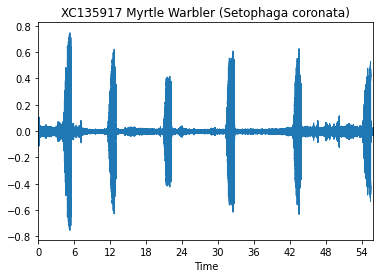

Imported Sample-rate is: 22050


In [99]:
# show the wavefrom of a random recording
train_audio_path = 'data/train_audio'

row = df.sample(1).iloc[0] # random row as series
path = os.path.join(train_audio_path, row['ebird_code'], row['filename'])
print(path)
data, sr = librosa.load(path, sr=22050, mono=True)
librosa.display.waveplot(data, sr= sr)
plt.title(row['title'])
plt.show()

# stats
print('Imported Sample-rate is:', sr)

# display playback
ipd.Audio(path)

In [100]:
data.shape

(1233792,)

In [101]:
sample_rate

22050

Notice the imported files are scaled from -1 to 1, sample rate converted to 22500, and converts to mono.

Extract MFCC audio features.

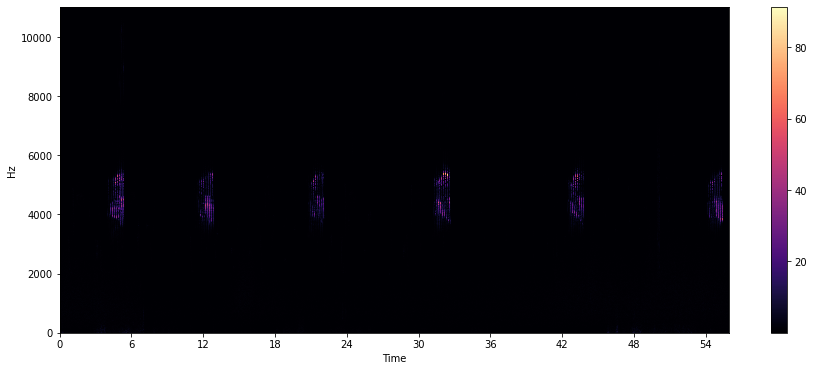

In [110]:
hop_length = 512
n_fft = 2048

stft = librosa.stft(data, n_fft=n_fft,  hop_length=hop_length)
spectrogram = np.abs(stft)

plt.figure(figsize=(15,6))
librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='hz')
plt.colorbar();

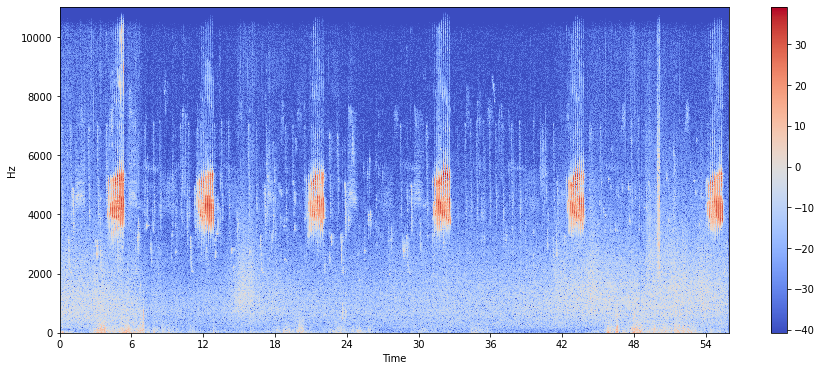

In [112]:
log_spectrogram = librosa.amplitude_to_db(spectrogram)
plt.figure(figsize=(15,6))
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='hz')
plt.colorbar();


In [102]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc = 40)
mfcc

array([[-2.6471664e+02, -2.5387589e+02, -2.7547049e+02, ...,
        -2.7648901e+02, -3.0033151e+02, -4.1144412e+02],
       [ 6.5580688e+01,  7.6839706e+01,  9.0903473e+01, ...,
         8.1976875e+01,  7.0758965e+01,  7.2742905e+01],
       [-2.3161745e+01, -2.7965250e+01, -4.2107178e+01, ...,
        -5.2880680e+01, -4.7083946e+01, -3.3651886e+01],
       ...,
       [ 1.9568548e+00,  4.0045652e+00,  2.6802073e+00, ...,
         3.5622306e+00,  3.9241800e+00,  1.1336989e+00],
       [-6.1721721e+00, -3.4248667e+00, -1.4295154e+00, ...,
        -3.7275319e+00, -4.3723431e+00, -3.2050748e+00],
       [-2.3902531e+00, -1.4724309e+00, -3.1958079e-01, ...,
         3.7593966e+00,  8.7604580e+00,  1.0927923e+01]], dtype=float32)

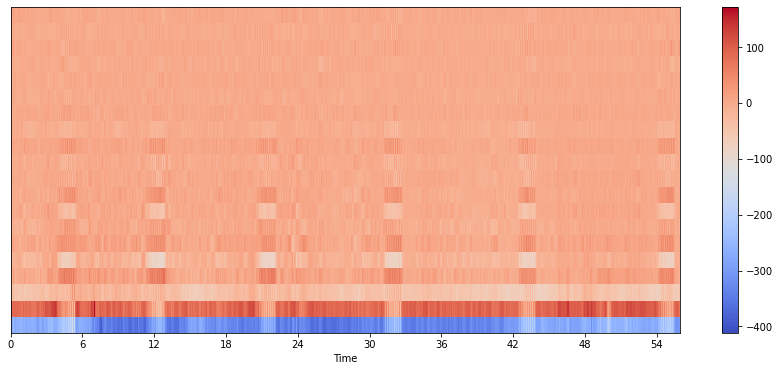

In [118]:
# visualize it
MFCCs = librosa.feature.mfcc(y=data, n_fft=n_fft, hop_length=hop_length,
                            sr=sr, n_mfcc = 20)
plt.figure(figsize=(15,6))
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length,
                     x_axis='time')

plt.ylabel='MFCC'
plt.colorbar();


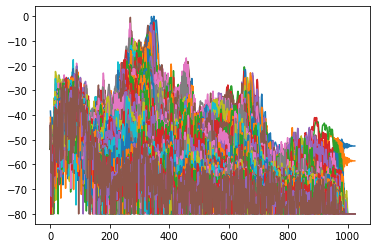

In [70]:
DB = librosa.amplitude_to_db(D, ref=np.max)
plt.plot(DB);

/Users/benbogart/opt/anaconda3/envs/audio-ml/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/benbogart/opt/anaconda3/envs/audio-ml/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/benbogart/opt/anaconda3/envs/audio-ml/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


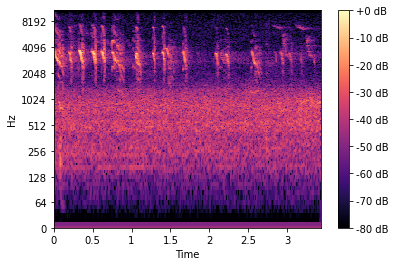

In [71]:
librosa.display.specshow(DB, sr=sample_rate, hop_length=256, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

/Users/benbogart/opt/anaconda3/envs/audio-ml/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/benbogart/opt/anaconda3/envs/audio-ml/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


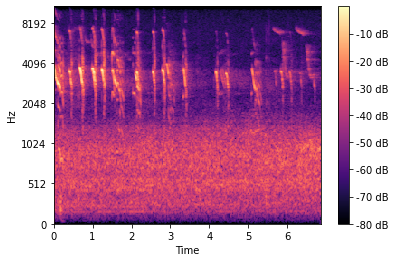

In [78]:
n_mels = 256
S = librosa.feature.melspectrogram(data, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');


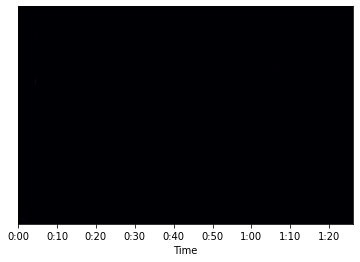

In [40]:
data_norm = librosa.util.normalize(data)
mel_norm = librosa.feature.melspectrogram(y=data_norm, sr=sample_rate, n_fft=1028)
librosa.display.specshow(mel_norm, sr=sample_rate, x_axis='time')


## how do the files compare

In [41]:
audio_files = glob(os.path.join('data/train_audio/*', '*.mp3'), recursive=True)
audio_files[:5]

['data/train_audio/olsfly/XC386256.mp3',
 'data/train_audio/olsfly/XC484154.mp3',
 'data/train_audio/olsfly/XC239498.mp3',
 'data/train_audio/olsfly/XC368006.mp3',
 'data/train_audio/olsfly/XC156193.mp3']

In [18]:
# Generate a DataFrame with info about the recordings
stats = {
    'duration': [],
    'sample_rate': [],
    'bitrate': [],
    'bird_id': [],
    'file_name': []
}

for af in tqdm(audio_files):    
    stats['duration'].append(sox.file_info.duration(af))
    stats['sample_rate'].append(sox.file_info.sample_rate(af))    
    stats['bitrate'].append(sox.file_info.bitrate(af))

    path_split = af.split('/')
    stats['bird_id'].append(path_split[-2])
    stats['file_name'].append(path_split[-1])

 84%|████████▎ | 17888/21375 [13:15<02:31, 23.00it/s]Duration unavailable for data/train_audio/amegfi/XC313679.mp3
Bit rate unavailable for data/train_audio/amegfi/XC313679.mp3
100%|██████████| 21375/21375 [15:45<00:00, 22.60it/s]


In [19]:
audio_files_df = pd.DataFrame(stats)

In [20]:
audio_files_df.head()

duration  sample_rate   bitrate bird_id     file_name
0  86.273000      48000.0  320000.0  olsfly  XC386256.mp3
1  13.023000      48000.0  323000.0  olsfly  XC484154.mp3
2  55.129002      44100.0  129000.0  olsfly  XC239498.mp3
3  13.391995      44100.0  130000.0  olsfly  XC368006.mp3
4  60.393991      44100.0  129000.0  olsfly  XC156193.mp3

Text(0.5, 1.0, 'File Duration')

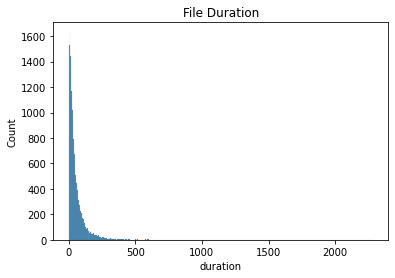

In [21]:
sns.histplot(audio_files_df['duration'])
plt.title('File Duration')

There are some definte outliers. We need to know if they have an example of the bird song at the beginning of the track and if they don't we should drop them.

In [22]:
audio_files_df[audio_files_df['duration'] > 20]

duration  sample_rate   bitrate bird_id     file_name
0       86.273000      48000.0  320000.0  olsfly  XC386256.mp3
2       55.129002      44100.0  129000.0  olsfly  XC239498.mp3
4       60.393991      44100.0  129000.0  olsfly  XC156193.mp3
5       57.338005      44100.0  113000.0  olsfly  XC430786.mp3
6      104.937007      44100.0  128000.0  olsfly  XC249977.mp3
...           ...          ...       ...     ...           ...
21347   70.355011      44100.0  128000.0  grnher  XC144306.mp3
21349   25.623991      44100.0  193000.0  grnher  XC319278.mp3
21353   25.971000      48000.0  130000.0  grnher  XC173633.mp3
21360   21.390000      48000.0  130000.0  grnher  XC253773.mp3
21374   28.759002      44100.0  193000.0  grnher  XC315553.mp3

[14434 rows x 5 columns]

In [23]:
# what are the longest files?
audio_files_df = audio_files_df.sort_values('duration', ascending=False)
audio_files_df.head()

duration  sample_rate   bitrate bird_id     file_name
1064   2283.936000      48000.0   80300.0  comrav  XC246425.mp3
20356  2240.612993      44100.0  320000.0  snobun  XC487556.mp3
20351  2138.572993      44100.0  320000.0  snobun  XC487557.mp3
20905  1285.213000      48000.0  320000.0  stejay  XC503349.mp3
7681   1093.650000      48000.0  320000.0  prawar  XC479026.mp3

Check the longest files to see if there is a bird song in the first 10 seconds.

In [27]:
ipd.set_matplotlib_close(close=True)

It does sound like we get the call in the first 10 seconds

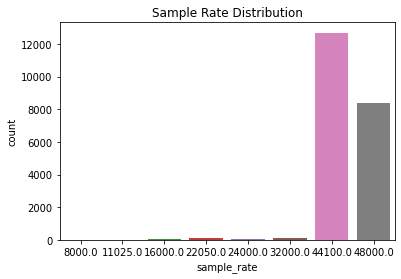

In [28]:
sns.countplot(x = audio_files_df['sample_rate'])
plt.title('Sample Rate Distribution');

Most of the files are at CD quality 44.1 khz.

Text(0.5, 1.0, 'Bitrate Distribution')

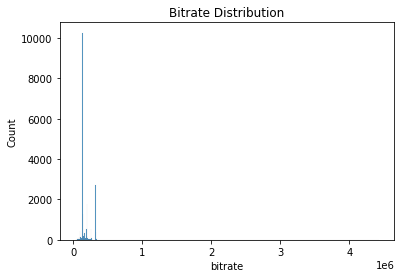

In [30]:
sns.histplot(audio_files_df['bitrate'])
plt.title('Bitrate Distribution')

There are some outliers with very high bitrates. Zoom in on < 500000

Text(0.5, 1.0, 'Bitrate (< 500k) Distribution')

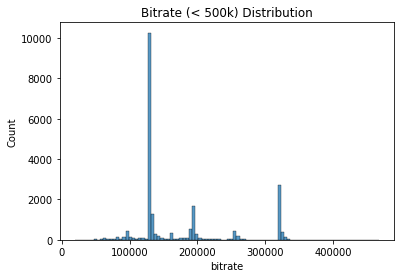

In [32]:
sns.histplot(audio_files_df[audio_files_df['bitrate'] < 500000]['bitrate'])
plt.title('Bitrate (< 500k) Distribution')

It looks like most of the files are above 128k or higher bitrate mp3 files.

In [33]:
## number of recordings for each bird_id

In [34]:
audio_files_df['bird_id'].value_counts()

pasfly    100
logshr    100
gnwtea    100
woothr    100
grhowl    100
         ... 
lecthr     20
coshum     19
hoomer     19
buffle     15
redhea      9
Name: bird_id, Length: 264, dtype: int64

In [35]:
# percentage of species with 100 samples
sum(audio_files_df['bird_id'].value_counts() == 100) / audio_files_df['bird_id'].nunique()

0.5075757575757576

In [36]:
# percentage of species with fewer than 50 samples
sum(audio_files_df['bird_id'].value_counts() <= 50) / audio_files_df['bird_id'].nunique()

0.17424242424242425

Half of the species have 100 samples but 17.4% of the species have fewer than 50 samples.  This could cause problems for our testing.  We will need to augment this data or acquire more.

In [38]:
#px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_geo(df,
                    lat=df.latitude,
                    lon=df.longitude,
                    title='Bird Recording Locations'
)
fig.show()

We could try to limit this to North America.  To do that we want to limit to species that have any observations in North America, even if some or even most are outside North America.

In [39]:
df[['latitude', 'longitude']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21375 entries, 0 to 21374
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   latitude   21375 non-null  object
 1   longitude  21375 non-null  object
dtypes: object(2)
memory usage: 334.1+ KB


In [40]:
df['latitude'].value_counts()

31.906           360
Not specified    226
28.2267          152
28.229           125
41.8605          114
                ... 
46.8384            1
57.6362            1
40.3321            1
69.3713            1
39.0785            1
Name: latitude, Length: 6989, dtype: int64

In [41]:
df = df.replace('Not specified', np.nan)
df.head()

rating playback_used ebird_code    channels        date pitch  duration  \
0     3.5            no     aldfly    1 (mono)  2013-05-25   NaN        25   
1     4.0            no     aldfly  2 (stereo)  2013-05-27  both        36   
2     4.0            no     aldfly  2 (stereo)  2013-05-27  both        39   
3     3.5            no     aldfly  2 (stereo)  2013-05-27  both        33   
4     4.0            no     aldfly  2 (stereo)  2013-05-27  both        36   

       filename  speed           species  ...   xc_id  \
0  XC134874.mp3    NaN  Alder Flycatcher  ...  134874   
1  XC135454.mp3   both  Alder Flycatcher  ...  135454   
2  XC135455.mp3   both  Alder Flycatcher  ...  135455   
3  XC135456.mp3   both  Alder Flycatcher  ...  135456   
4  XC135457.mp3  level  Alder Flycatcher  ...  135457   

                                 url        country            author  \
0  https://www.xeno-canto.org/134874  United States  Jonathon Jongsma   
1  https://www.xeno-canto.org/135454  United States       Mike Nelson   
2  https://www.xeno-canto.org/135455  United States       Mike Nelson   
3  https://www.xeno-canto.org/135456  United States       Mike Nelson   
4  https://www.xeno-canto.org/135457  United States       Mike Nelson   

                        primary_label longitude  length   time  \
0  Empidonax alnorum_Alder Flycatcher   -92.962     NaN   8:00   
1  Empidonax alnorum_Alder Flycatcher  -82.1106  0-3(s)  08:30   
2  Empidonax alnorum_Alder Flycatcher  -82.1106  0-3(s)  08:30   
3  Empidonax alnorum_Alder Flycatcher  -82.1106  0-3(s)  08:30   
4  Empidonax alnorum_Alder Flycatcher  -82.1106  0-3(s)  08:30   

          recordist                                            license  
0  Jonathon Jongsma        Creative Commons Attribution-ShareAlike 3.0  
1       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
2       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
3       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
4       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  

[5 rows x 35 columns]

In [46]:
df_ll = df.dropna(subset=['latitude', 'longitude']).copy()

In [47]:
# How many rows did we drop
len(df) - len(df_ll)

226

In [48]:
# Convert lat long to float
df_ll[['latitude', 'longitude']] = df_ll[['latitude', 'longitude']].astype('float')
df_ll.head()

rating playback_used ebird_code    channels        date pitch  duration  \
0     3.5            no     aldfly    1 (mono)  2013-05-25   NaN        25   
1     4.0            no     aldfly  2 (stereo)  2013-05-27  both        36   
2     4.0            no     aldfly  2 (stereo)  2013-05-27  both        39   
3     3.5            no     aldfly  2 (stereo)  2013-05-27  both        33   
4     4.0            no     aldfly  2 (stereo)  2013-05-27  both        36   

       filename  speed           species  ...   xc_id  \
0  XC134874.mp3    NaN  Alder Flycatcher  ...  134874   
1  XC135454.mp3   both  Alder Flycatcher  ...  135454   
2  XC135455.mp3   both  Alder Flycatcher  ...  135455   
3  XC135456.mp3   both  Alder Flycatcher  ...  135456   
4  XC135457.mp3  level  Alder Flycatcher  ...  135457   

                                 url        country            author  \
0  https://www.xeno-canto.org/134874  United States  Jonathon Jongsma   
1  https://www.xeno-canto.org/135454  United States       Mike Nelson   
2  https://www.xeno-canto.org/135455  United States       Mike Nelson   
3  https://www.xeno-canto.org/135456  United States       Mike Nelson   
4  https://www.xeno-canto.org/135457  United States       Mike Nelson   

                        primary_label longitude  length   time  \
0  Empidonax alnorum_Alder Flycatcher  -92.9620     NaN   8:00   
1  Empidonax alnorum_Alder Flycatcher  -82.1106  0-3(s)  08:30   
2  Empidonax alnorum_Alder Flycatcher  -82.1106  0-3(s)  08:30   
3  Empidonax alnorum_Alder Flycatcher  -82.1106  0-3(s)  08:30   
4  Empidonax alnorum_Alder Flycatcher  -82.1106  0-3(s)  08:30   

          recordist                                            license  
0  Jonathon Jongsma        Creative Commons Attribution-ShareAlike 3.0  
1       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
2       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
3       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
4       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  

[5 rows x 35 columns]

Check each bird_code to see if it has recordings in North America

In [49]:
lat_min = 20 
lat_max = 70
long_min = -170
long_max = -53

In [50]:
# create df with max/min lat/long for each species
df_geo_range = df_ll[['ebird_code', 'latitude', 'longitude']].groupby('ebird_code').agg(['max', 'min'])
df_geo_range.head()

latitude          longitude          
                max      min       max       min
ebird_code                                      
aldfly      63.9716 -19.5501  -62.5623 -151.6030
ameavo      48.4183  18.0024  -80.7645 -122.1050
amebit      56.7264  28.2267  -70.7935 -124.0975
amecro      56.0883  25.1380  -68.9242 -129.3039
amegfi      52.1990  28.2366  -63.0049 -124.0271

In [51]:
df_geo_range['latitude', 'min'] < lat_max

ebird_code
aldfly    True
ameavo    True
amebit    True
amecro    True
amegfi    True
          ... 
yebsap    True
yehbla    True
yelwar    True
yerwar    True
yetvir    True
Name: (latitude, min), Length: 264, dtype: bool

In [52]:
n_america_idx = df_geo_range[(df_geo_range['latitude', 'max'] > lat_min) 
                             & (df_geo_range['latitude', 'min'] < lat_max)
                             & (df_geo_range['longitude', 'max'] > long_min)
                             & (df_geo_range['longitude', 'min'] < long_max)].index
n_america_idx

Index(['aldfly', 'ameavo', 'amebit', 'amecro', 'amegfi', 'amekes', 'amepip',
       'amered', 'amerob', 'amewig',
       ...
       'wooduc', 'wooscj2', 'woothr', 'y00475', 'yebfly', 'yebsap', 'yehbla',
       'yelwar', 'yerwar', 'yetvir'],
      dtype='object', name='ebird_code', length=262)

In [53]:
na_df = df_ll[df_ll['ebird_code'].isin(n_america_idx)]
na_df.head()

rating playback_used ebird_code    channels        date pitch  duration  \
0     3.5            no     aldfly    1 (mono)  2013-05-25   NaN        25   
1     4.0            no     aldfly  2 (stereo)  2013-05-27  both        36   
2     4.0            no     aldfly  2 (stereo)  2013-05-27  both        39   
3     3.5            no     aldfly  2 (stereo)  2013-05-27  both        33   
4     4.0            no     aldfly  2 (stereo)  2013-05-27  both        36   

       filename  speed           species  ...   xc_id  \
0  XC134874.mp3    NaN  Alder Flycatcher  ...  134874   
1  XC135454.mp3   both  Alder Flycatcher  ...  135454   
2  XC135455.mp3   both  Alder Flycatcher  ...  135455   
3  XC135456.mp3   both  Alder Flycatcher  ...  135456   
4  XC135457.mp3  level  Alder Flycatcher  ...  135457   

                                 url        country            author  \
0  https://www.xeno-canto.org/134874  United States  Jonathon Jongsma   
1  https://www.xeno-canto.org/135454  United States       Mike Nelson   
2  https://www.xeno-canto.org/135455  United States       Mike Nelson   
3  https://www.xeno-canto.org/135456  United States       Mike Nelson   
4  https://www.xeno-canto.org/135457  United States       Mike Nelson   

                        primary_label longitude  length   time  \
0  Empidonax alnorum_Alder Flycatcher  -92.9620     NaN   8:00   
1  Empidonax alnorum_Alder Flycatcher  -82.1106  0-3(s)  08:30   
2  Empidonax alnorum_Alder Flycatcher  -82.1106  0-3(s)  08:30   
3  Empidonax alnorum_Alder Flycatcher  -82.1106  0-3(s)  08:30   
4  Empidonax alnorum_Alder Flycatcher  -82.1106  0-3(s)  08:30   

          recordist                                            license  
0  Jonathon Jongsma        Creative Commons Attribution-ShareAlike 3.0  
1       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
2       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
3       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  
4       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  

[5 rows x 35 columns]

In [55]:
len(na_df)

20949

In [56]:
# how many files have we eliminated?
len(df) - len(na_df)

426

In [58]:
#plot it
fig = px.scatter_geo(df,
                    lat=na_df.latitude,
                    lon=na_df.longitude,
                    title='Bird Recording Locations for North American Species'
                    )
fig.show()